# LLM + RLHF Workshop

## About Author

Alex Golubev - Sr. ML Engineer @ Constructor.io

Singularis - @alex_golubev

LinkedIn - https://www.linkedin.com/in/alexander-golubev-79064117b/



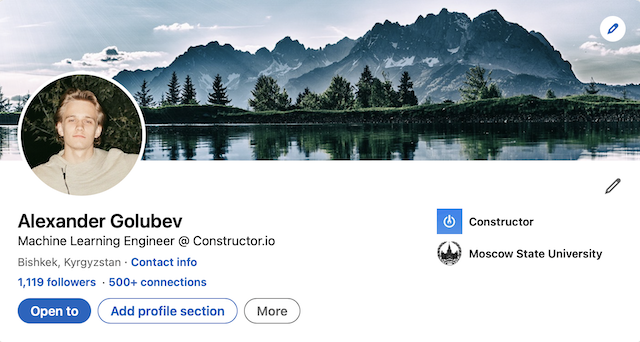

## Preliminary functions

In [ ]:
import sys
!{sys.executable} -m pip install trl accelerate bitsandbytes loralib
!{sys.executable} -m pip install addict evaluate
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/peft
!{sys.executable} -m pip install --upgrade git+https://github.com/huggingface/transformers
!{sys.executable} -m pip install --upgrade git+https://github.com/lvwerra/trl

In [ ]:
!nvidia-smi

Mon May 15 17:29:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import textwrap

from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

EVAL_PROMPTS = [
    "Question: How to create an attention layer in pytorch? \n\n Answer: ",
    "Question: I recieve TypeError with a following code: ```a=[1, 2, 3]    a.extend(4)```. How can I fix it?  \n\n Answer: ",
    "Question: What library would you recommend for visualizing 3D points in python? \n\n Answer: ",
]

def generate_eval(model: AutoModelForCausalLM, tokenizer: AutoTokenizer):
    print("Starting Evaluation...")
    model = model.to(device)
    model.eval()
    for eval_prompt in EVAL_PROMPTS:
        batch = tokenizer(eval_prompt, return_tensors="pt").to(device)

        with torch.cuda.amp.autocast():
            output_tokens = model.generate(**batch, max_new_tokens=128)

        print("\n\n", textwrap.fill(tokenizer.decode(output_tokens[0], skip_special_tokens=False)))
        print("*"*100)

## GPT Neo Text Generation

In [ ]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
generate_eval(model, tokenizer)

Starting Evaluation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: How to create an attention layer in pytorch?    Answer:
The attention layer is a layer that takes the output of the last layer
and adds it to the input of the next layer.   The attention layer is a
layer that takes the output of the last layer and adds it to the input
of the next layer.   The attention layer is a layer that takes the
output of the last layer and adds it to the input of the next layer.
The attention layer is a layer that takes the output of the last layer
and adds it to the input of the next layer.   The attention layer is a
layer that takes the output of the last layer
****************************************************************************************************


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: I recieve TypeError with a following code: ```a=[1, 2, 3]
a.extend(4)```. How can I fix it?     Answer:   You can't extend an
array.    A:  You can't extend an array.  You can extend an object.
You can extend an array.  A:  You can't extend an array.  You can
extend an object.  You can extend an array.  A:  You can't extend an
array.  You can extend an object.  You can extend an array.  A:  You
can't extend an array.  You can extend an object.  You can extend an
array.
****************************************************************************************************


 Question: What library would you recommend for visualizing 3D points
in python?    Answer:   I would recommend the pyQt library.   A:  I
would recommend the pyQt library.   A:  I would recommend the pyQt
library.   A:  I would recommend the pyQt library.   A:  I would
recommend the pyQt library.   A:  I would recommend the pyQt library.
A:  I would recommend the pyQt library.   A:  I would recommend the
py

## GPT Neo Supervised Fine-Tuning (SFT)

### Tricks for efficient single gpu training

**Large models usually don't fit into a single GPU**

---


Efficient Single GPU training: https://huggingface.co/docs/transformers/perf_train_gpu_one
- Gradient accumulation
- Gradient checkpointing
- Floating data types (fp16, bfp16, ...)
- Adafactor optimizer

<div>
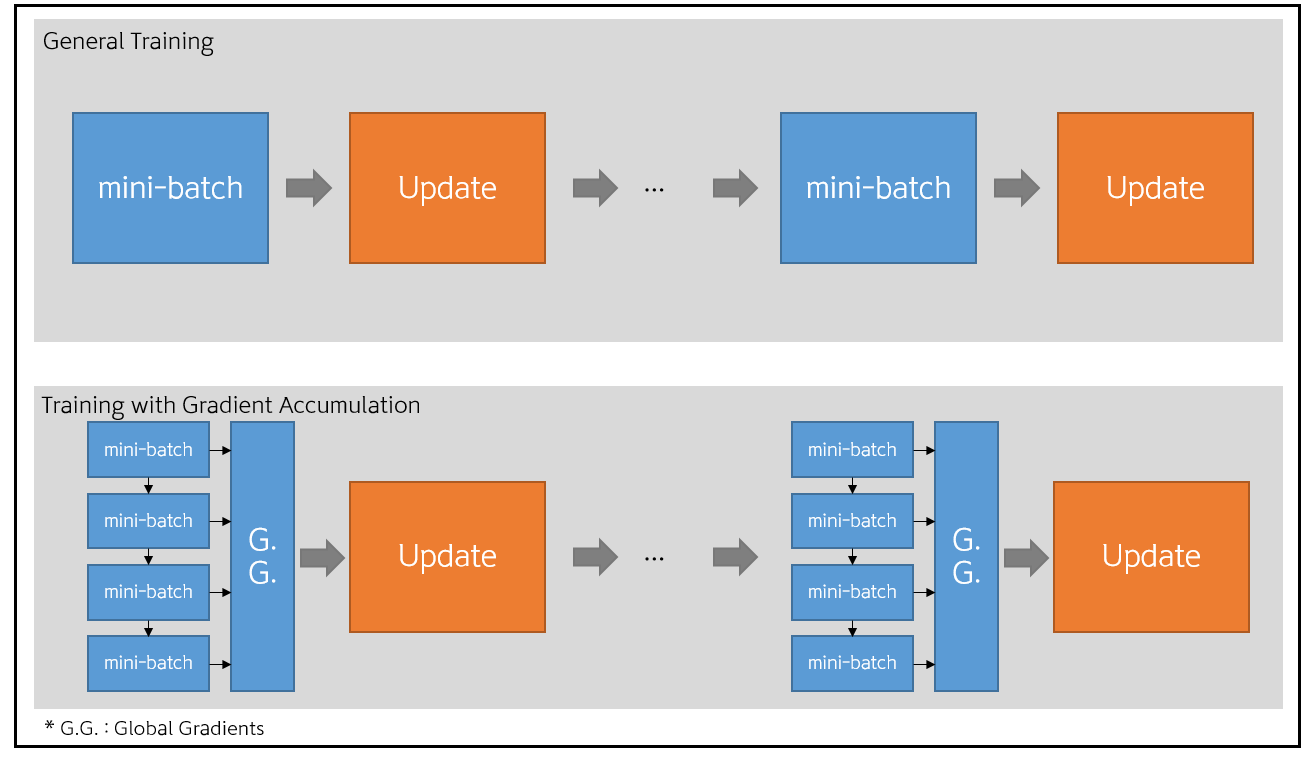
</div>

<div>
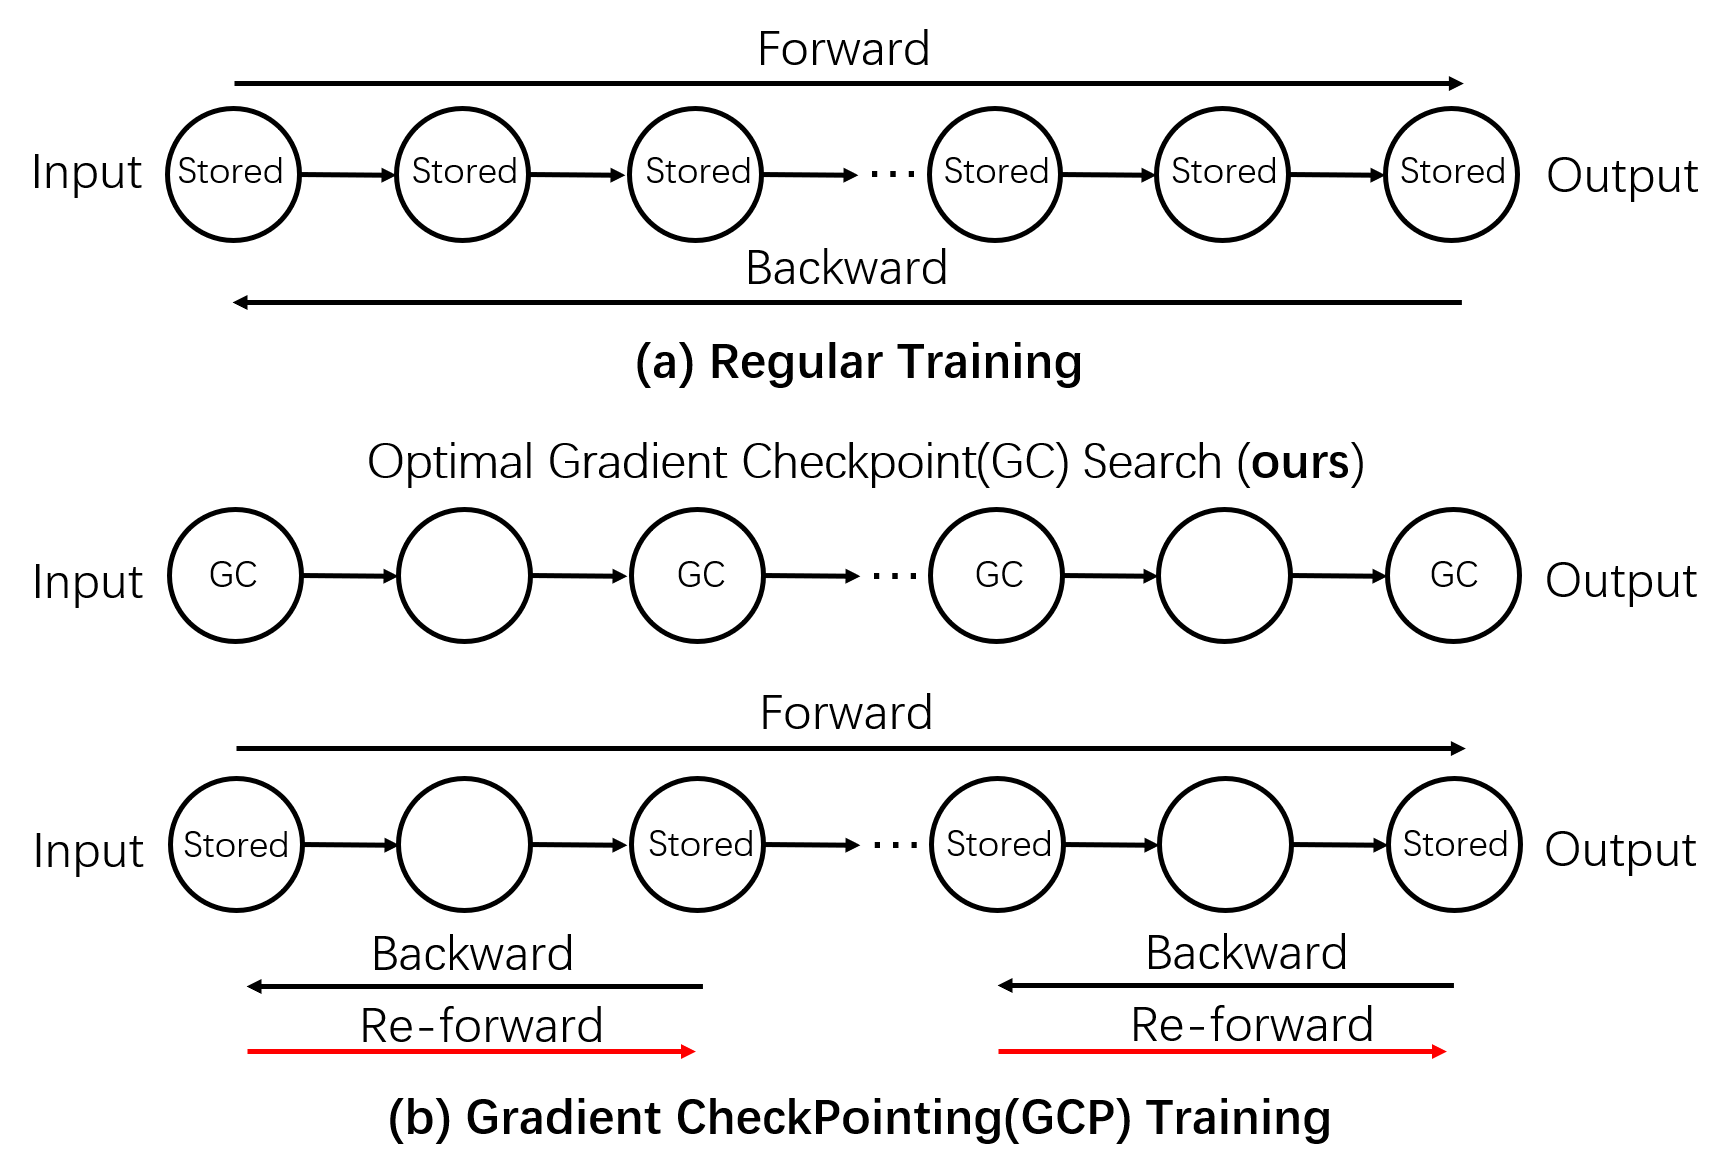
</div>

<div>
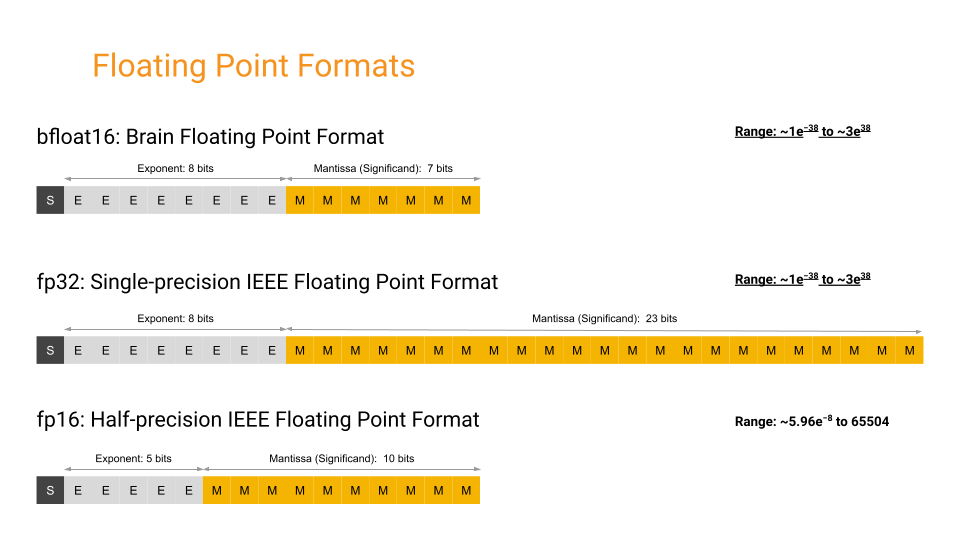
</div>

**LLM.int8() original paper:** https://arxiv.org/abs/2208.07339

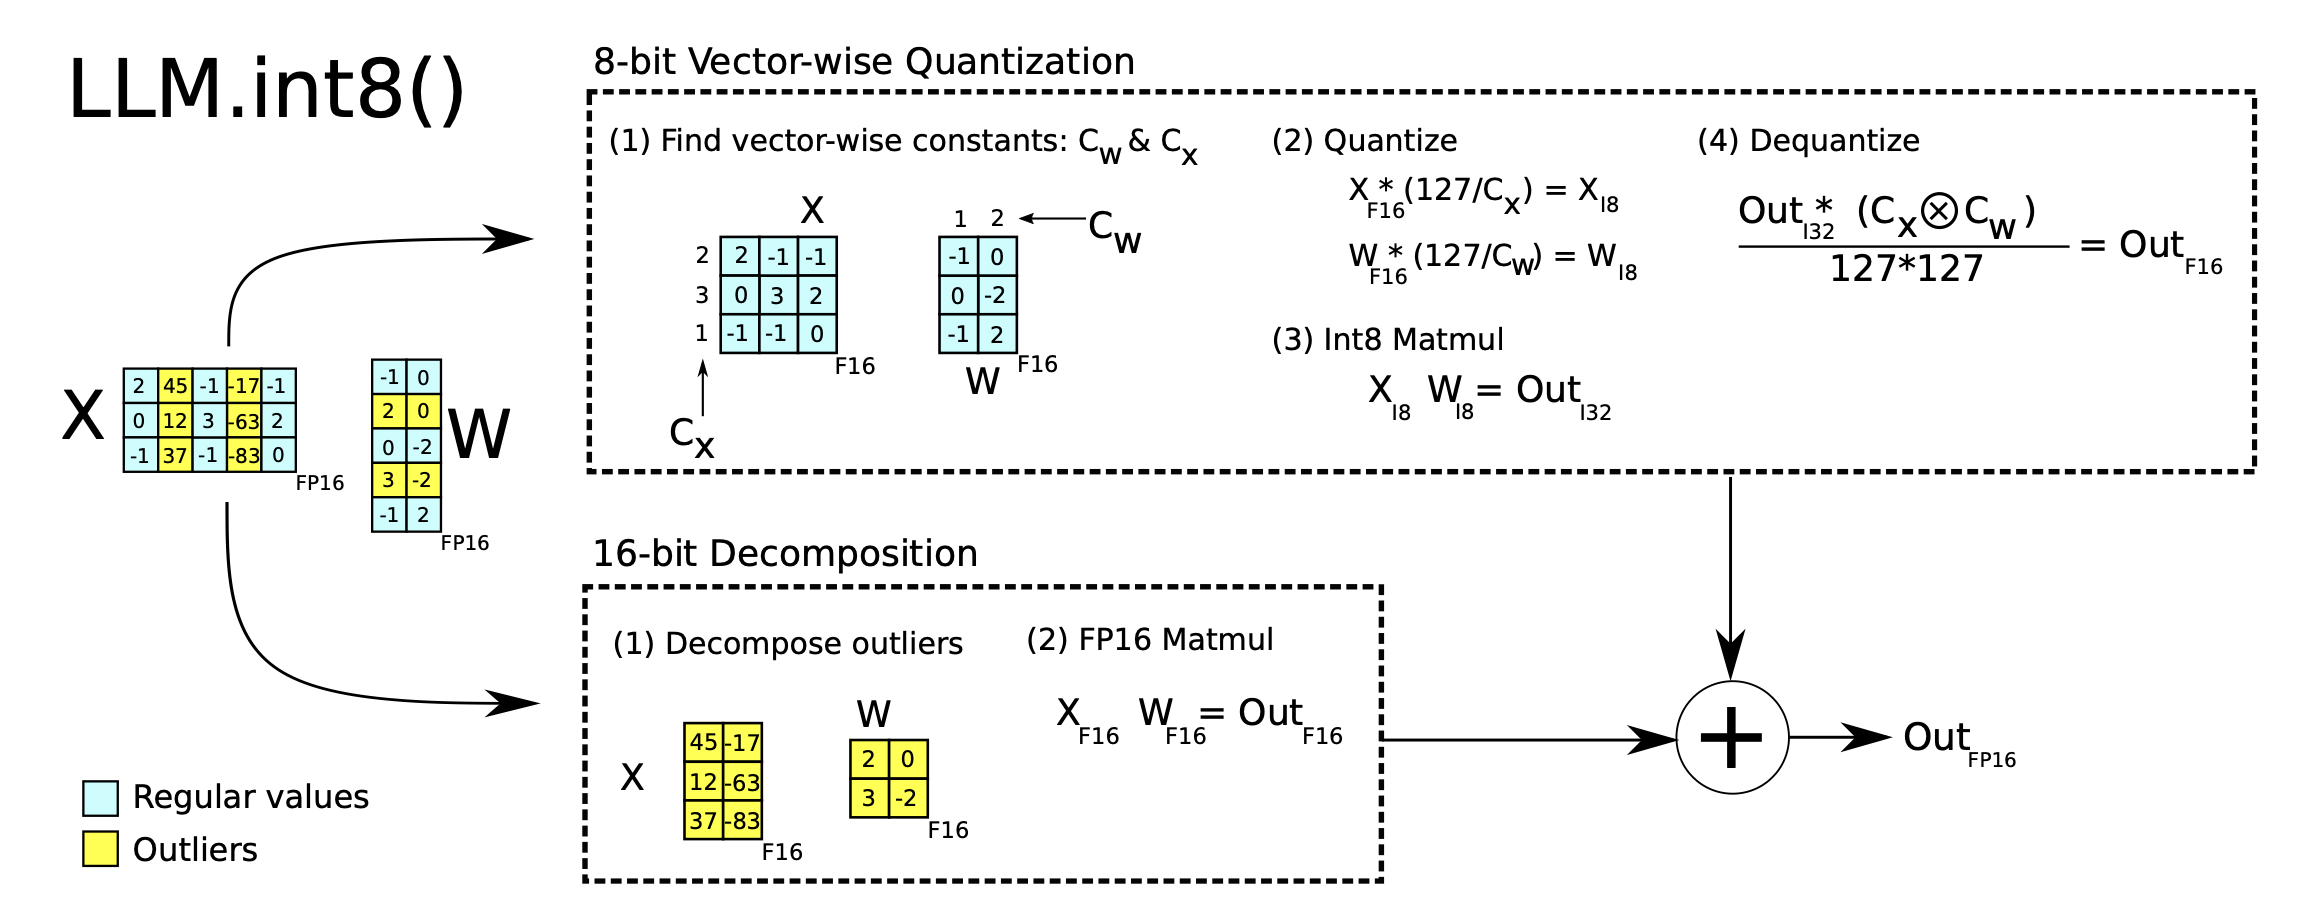

### LoRA Adapters for SFT

In [ ]:
import os
import addict
import torch
import peft
import bitsandbytes as bnb

from tqdm import tqdm
from torch.utils.data import IterableDataset
from peft import PeftModel, LoraConfig, get_peft_model, prepare_model_for_int8_training
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    logging,
    set_seed
)
from accelerate import Accelerator
from datasets import load_dataset

**LoRA Adapter original paper:** https://arxiv.org/pdf/2106.09685.pdf

<div>
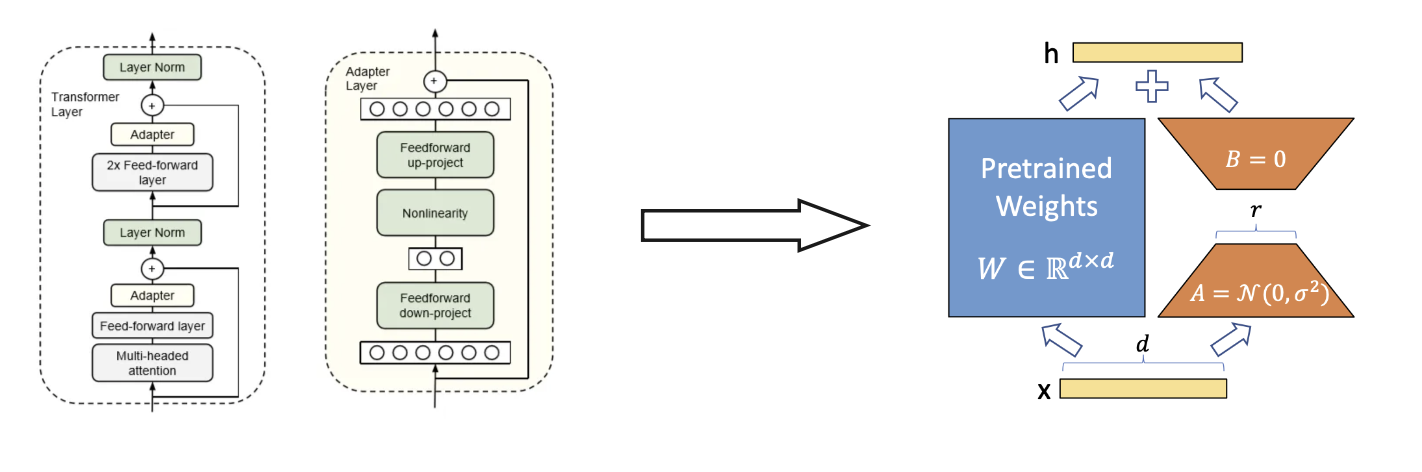
</div>

https://github.com/huggingface/peft/blob/main/src/peft/tuners/lora.py#L436

In [ ]:
# load model in 8bit
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-1.3B",
    load_in_8bit=True,
    device_map={'':torch.cuda.current_device()}
)

model = prepare_model_for_int8_training(model)

# add LoRA to model
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model.enable_input_require_grads()
model = get_peft_model(model, lora_config).to(device)

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


### Preparing Data for SFT

<div>
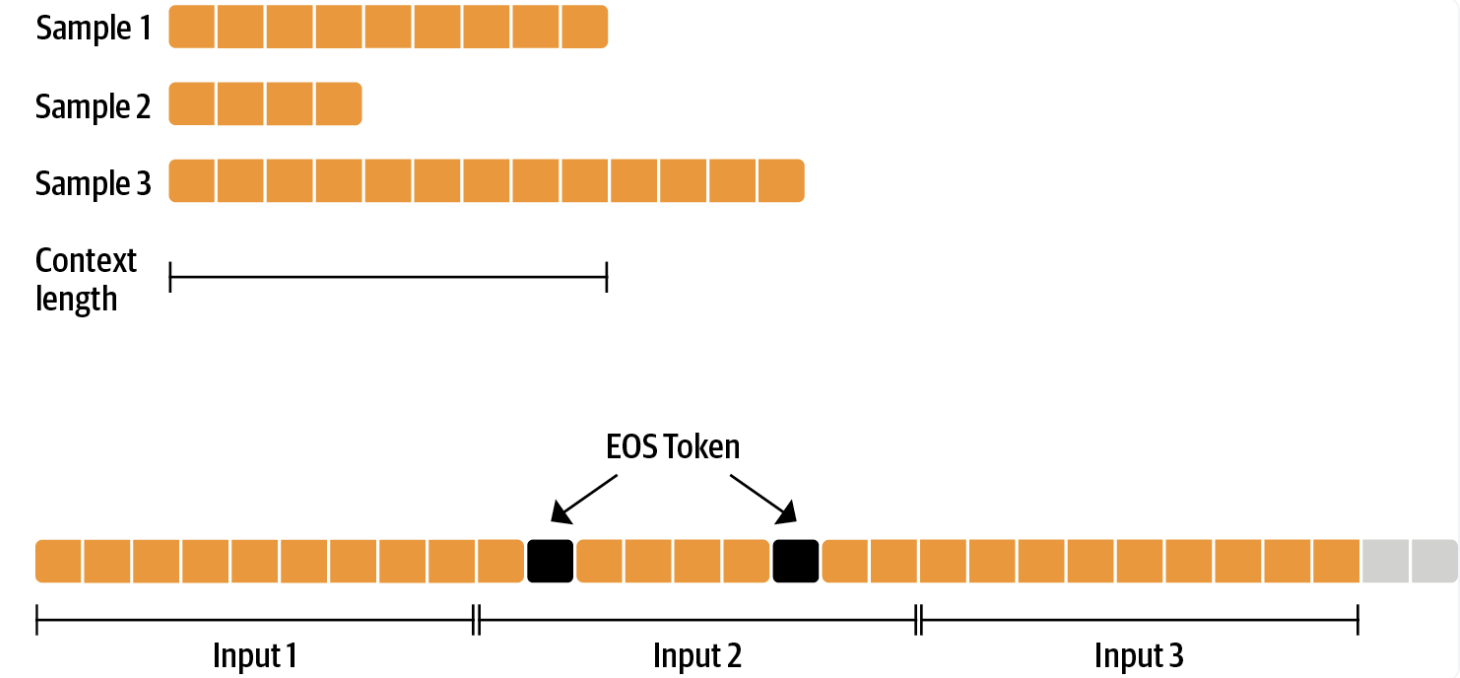
</div>

In [ ]:
class ConstantLengthDataset(IterableDataset):
    """
    Iterable dataset that returns constant length chunks of tokens from stream of text files.
        Args:
            tokenizer (Tokenizer): The processor used for proccessing the data.
            dataset (dataset.Dataset): Dataset with text files.
            infinite (bool): If True the iterator is reset after dataset reaches end else stops.
            seq_length (int): Length of token sequences to return.
            num_of_sequences (int): Number of token sequences to keep in buffer.
            chars_per_token (int): Number of characters per token used to estimate number of tokens in text buffer.
    """

    def __init__(
        self,
        tokenizer,
        dataset,
        infinite=False,
        seq_length=1024,
        num_of_sequences=1024,
        chars_per_token=3.6,
    ):
        self.tokenizer = tokenizer
        self.concat_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id else args.eos_token_id
        self.dataset = dataset
        self.seq_length = seq_length
        self.infinite = infinite
        self.current_size = 0
        self.max_buffer_size = seq_length * chars_per_token * num_of_sequences

    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.max_buffer_size:
                    break
                try:
                    buffer.append(prepare_sample_text(next(iterator)))
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    if self.infinite:
                        iterator = iter(self.dataset)
                    else:
                        more_examples = False
                        break
            tokenized_inputs = self.tokenizer(buffer, truncation=False)["input_ids"]
            all_token_ids = []
            for tokenized_input in tokenized_inputs:
                all_token_ids.extend(tokenized_input + [self.concat_token_id])
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    self.current_size += 1
                    yield {
                        "input_ids": torch.LongTensor(input_ids),
                        "labels": torch.LongTensor(input_ids),
                    }

def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""
    text = f"Question: {example['question']}\n\nAnswer: {example['response_j']}"
    return text

def chars_token_ratio(dataset, tokenizer, nb_examples=400):
    """
    Estimate the average number of characters per token in the dataset.
    """
    total_characters, total_tokens = 0, 0
    for _, example in tqdm(zip(range(nb_examples), iter(dataset)), total=nb_examples):
        text = prepare_sample_text(example)
        total_characters += len(text)
        if tokenizer.is_fast:
            total_tokens += len(tokenizer(text).tokens())
        else:
            total_tokens += len(tokenizer.tokenize(text))

    return total_characters / total_tokens

In [ ]:
def create_datasets(tokenizer, cfg):
    dataset = load_dataset(
        cfg.dataset_name,
        data_dir=cfg.subset,
        split=cfg.split,
        use_auth_token=True,
        num_proc=cfg.num_workers if not cfg.streaming else None,
        streaming=cfg.streaming,
    )
    if cfg.streaming:
        print("Loading the dataset in streaming mode")
        valid_data = dataset.take(cfg.size_valid_set)
        train_data = dataset.skip(cfg.size_valid_set)
        train_data = train_data.shuffle(buffer_size=cfg.shuffle_buffer, seed=cfg.seed)
    else:
        dataset = dataset.train_test_split(test_size=0.005, seed=cfg.seed)
        train_data = dataset["train"]
        valid_data = dataset["test"]
        print(f"Size of the train set: {len(train_data)}. Size of the validation set: {len(valid_data)}")

    chars_per_token = chars_token_ratio(train_data, tokenizer)
    print(f"The character to token ratio of the dataset is: {chars_per_token:.2f}")

    train_dataset = ConstantLengthDataset(
        tokenizer,
        train_data,
        infinite=True,
        seq_length=cfg.seq_length,
        chars_per_token=chars_per_token,
    )
    valid_dataset = ConstantLengthDataset(
        tokenizer,
        valid_data,
        infinite=False,
        seq_length=cfg.seq_length,
        chars_per_token=chars_per_token,
    )
    return train_dataset, valid_dataset

### Config for SFT

In [ ]:
cfg = addict.Dict(
      {
        "dataset_name": "lvwerra/stack-exchange-paired",
        "max_steps": 4000,
        "batch_size": 16,
        "learning_rate": 1e-4,
        "gradient_accumulation_steps": 1,
        "lr_scheduler_type": "cosine",
        "fp16": True,
        "gradient_checkpointing": True,
        "weight_decay": 0.05,
        "num_warmup_steps": 100,
       ##########
        "subset": "data/finetune",
        "split": "train",
        "size_valid_set": 4000,
        "streaming": True,
        "shuffle_buffer": 5000,
        "seq_length": 1024,
        "local_rank": 0,
        "seed": 0,
        "num_workers": None,
        "output_dir": "./checkpoints",
        "log_freq": 1,
        "eval_freq": 1000,
        "save_freq": 1000,
  }
)

In [ ]:
print_trainable_parameters(model)

trainable params: 3145728 || all params: 1318721536 || trainable%: 0.23854376486045345


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
train_dataset, eval_dataset = create_datasets(tokenizer, cfg)

### Model Training

In [ ]:
train_dataset.start_iteration = 0

print("Starting main loop")

training_args = TrainingArguments(
    output_dir=cfg.output_dir,
    dataloader_drop_last=True,
    evaluation_strategy="steps",
    max_steps=cfg.max_steps,
    eval_steps=cfg.eval_freq,
    save_steps=cfg.save_freq,
    logging_steps=cfg.log_freq,
    per_device_train_batch_size=cfg.batch_size,
    per_device_eval_batch_size=cfg.batch_size,
    learning_rate=cfg.learning_rate,
    lr_scheduler_type=cfg.lr_scheduler_type,
    warmup_steps=cfg.num_warmup_steps,
    gradient_accumulation_steps=cfg.gradient_accumulation_steps,
    gradient_checkpointing=cfg.gradient_checkpointing,
    fp16=cfg.fp16,
    weight_decay=cfg.weight_decay,
)

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)

print("Training...")
trainer.train()

print("Saving last checkpoint of the model")
model.save_pretrained(os.path.join(cfg.output_dir, "final_checkpoint/"))

Starting main loop
Training...


Step,Training Loss,Validation Loss
1000,1.943500,1.414417
2000,1.691200,1.403165
3000,1.391500,1.394777
4000,1.599200,1.395175


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Saving last checkpoint of the model


### Merging and Uploading to HuggingFace Storage



<div>
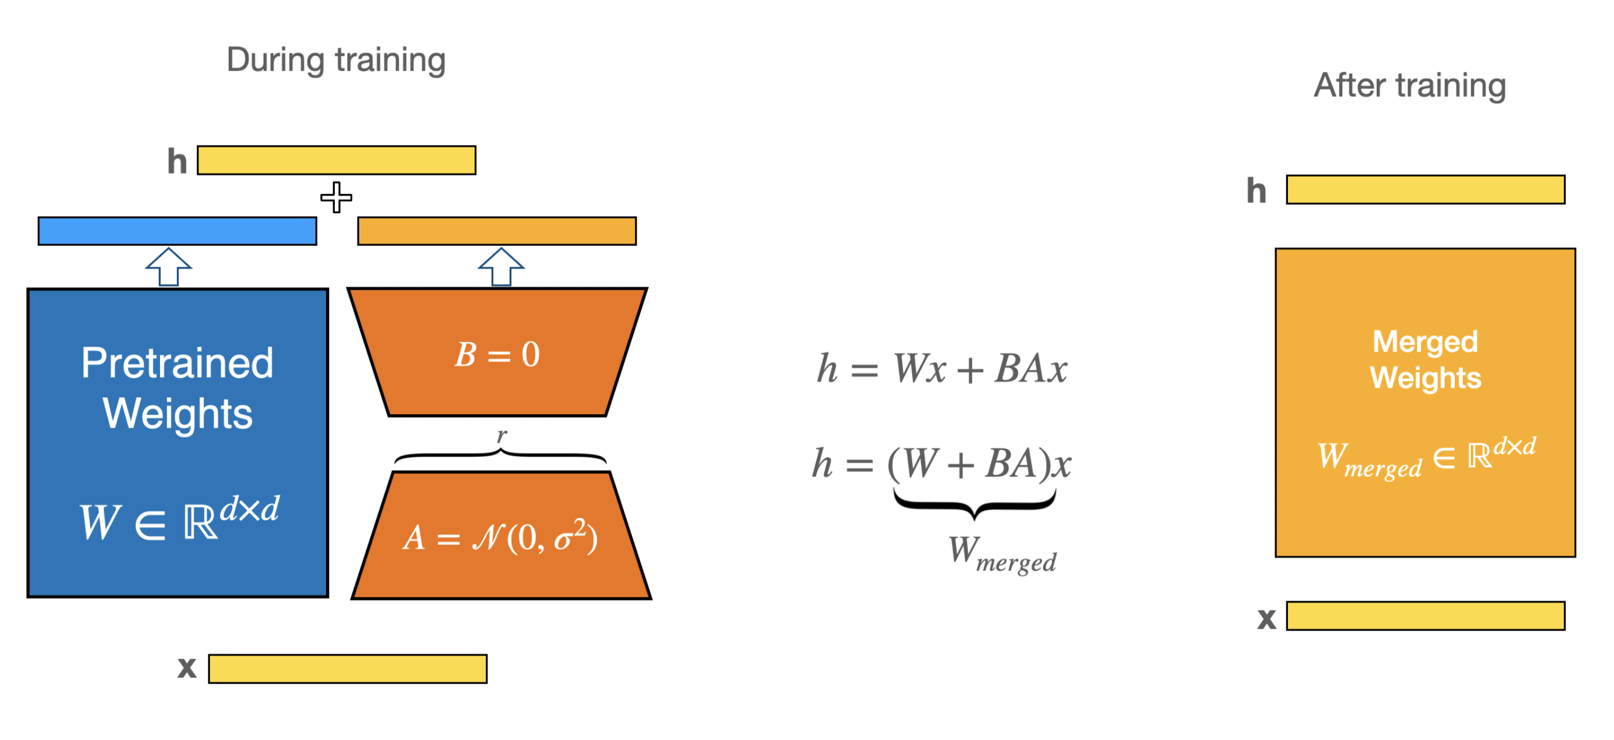
</div>

In [ ]:
model_sft = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-1.3B",
    torch_dtype=torch.float16,
    device_map={'':torch.cuda.current_device()}
)

model_sft = PeftModel.from_pretrained(model_sft, "./checkpoints/final_checkpoint")

In [ ]:
model_sft.save_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps-lora")
model_sft.push_to_hub(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps-lora", use_temp_dir=False)

In [ ]:
model_sft = model_sft.merge_and_unload()
model_sft.save_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps")
model_sft.push_to_hub(f"djalexj/gpt-neo-1.3B-sft-se-{cfg.max_steps}steps", use_temp_dir=False)

In [ ]:
# Load the Lora model
model = AutoModelForCausalLM.from_pretrained(f"djalexj/gpt-neo-1.3B-sft-se-4000steps")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

generate_eval(model, tokenizer)

Starting Evaluation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: How to create an attention layer in pytorch?    Answer:
``` import torch import torch.nn as nn import torch.nn.functional as F
class Attention(nn.Module):     def __init__(self, input_dim,
output_dim, attention_dim):         super(Attention, self).__init__()
self.input_dim = input_dim         self.output_dim = output_dim
self.attention_dim = attention_dim
****************************************************************************************************


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: I recieve TypeError with a following code: ```a=[1, 2, 3]
a.extend(4)```. How can I fix it?     Answer:   ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend an empty
list.  ``` a = [1, 2, 3] a.extend(4)  ```  This is because you are
trying to extend a list with a single element.  ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend a list with
two elements.  ``
****************************************************************************************************


 Question: What library would you recommend for visualizing 3D points
in python?    Answer:   I would recommend the [3D-modeling
library](http://www.3dmodeling.com/). It is a very good library for 3D
modeling. It has a lot of features, including:  * A very good
documentation * A very good API * A very good community * A very good
community support * A very good community documentation * A very good
community forum * A very good community wiki * A very good community

## Reward Model (RM)

### RLHF

Reinforcement Learning from Human Feedback (RLHF) is a technique of training models by combining classical RL algorithms and human-generated evaluations of the model's outputs as a measure of performance.

(c) ChatGPT-4


**It basically consists of:**


1.   Pretraining a language model (LM),
2.   Gathering data and training a reward model, and
3.   Fine-tuning the LM with reinforcement learning.






<div>
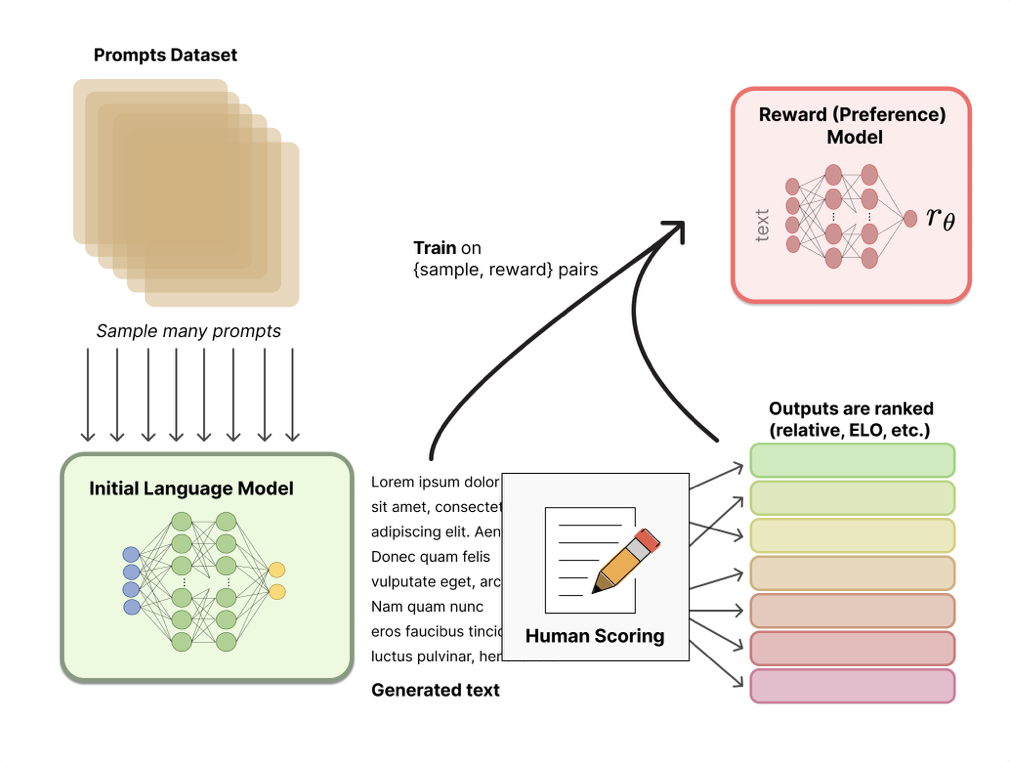
</div>

In [ ]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

import evaluate
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from peft import LoraConfig, PeftModel, TaskType, get_peft_model, prepare_model_for_int8_training
import addict
from transformers import (
    AutoModel,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    HfArgumentParser,
    PreTrainedTokenizerBase,
    Trainer,
    TrainingArguments,
)
from transformers.utils import PaddingStrategy

### Config for Reward Model

In [ ]:
cfg_reward = addict.Dict({
    "model_name": "bert-base-cased",
    "num_train_epochs": 1,
    "train_subset": 100_000,
    "eval_subset": 20_000,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "lr_scheduler_type": "linear",
    "weight_decay": 0.05,
    "learning_rate": 2e-5,
    "bf16": False,
    "fp16": False,
    ######
    "per_device_eval_batch_size": 64,
    "per_device_train_batch_size": 64,
    "local_rank": 0,
})

### Preparing Data for RM

In [ ]:
# Load the human stack-exchange-paired dataset for tuning the reward model
train_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/reward", split="train")
if cfg_reward.train_subset > 0:
    train_dataset = train_dataset.select(range(cfg_reward.train_subset))
eval_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/evaluation", split="train")
if cfg_reward.eval_subset > 0:
    eval_dataset = eval_dataset.select(range(cfg_reward.eval_subset))

model_name_split = cfg_reward.model_name.split("/")[-1]
output_name = (
    f"{model_name_split}_peft_stack-exchange-paired_rmts_{cfg_reward.train_subset}_{cfg_reward.learning_rate}"
)

original_columns = train_dataset.column_names
num_proc = 2  # Can adjust to be higher if you have more processors

In [ ]:
# Turn the dataset into pairs of post + summaries, where text_j is the preferred question + answer and text_k is the other.
# Then tokenize the dataset.
def preprocess_function(examples):
    new_examples = {
        "input_ids_j": [],
        "attention_mask_j": [],
        "input_ids_k": [],
        "attention_mask_k": [],
    }
    for question, response_j, response_k in zip(examples["question"], examples["response_j"], examples["response_k"]):
        tokenized_j = tokenizer("Question: " + question + "\n\nAnswer: " + response_j, truncation=True)
        tokenized_k = tokenizer("Question: " + question + "\n\nAnswer: " + response_k, truncation=True)

        new_examples["input_ids_j"].append(tokenized_j["input_ids"])
        new_examples["attention_mask_j"].append(tokenized_j["attention_mask"])
        new_examples["input_ids_k"].append(tokenized_k["input_ids"])
        new_examples["attention_mask_k"].append(tokenized_k["attention_mask"])

    return new_examples


# preprocess the dataset and filter out QAs that are longer than 512
train_dataset = train_dataset.map(
    preprocess_function, batched=True, num_proc=num_proc, remove_columns=original_columns
)
train_dataset = train_dataset.filter(lambda x: len(x["input_ids_j"]) <= 512 and len(x["input_ids_k"]) <= 512)

eval_dataset = eval_dataset.map(preprocess_function, batched=True, num_proc=num_proc, remove_columns=original_columns)
eval_dataset = eval_dataset.filter(lambda x: len(x["input_ids_j"]) <= 512 and len(x["input_ids_k"]) <= 512)

In [ ]:
training_args = TrainingArguments(
    output_dir=output_name,
    learning_rate=cfg_reward.learning_rate,
    per_device_train_batch_size=cfg_reward.per_device_train_batch_size,
    per_device_eval_batch_size=cfg_reward.per_device_eval_batch_size,
    num_train_epochs=cfg_reward.num_train_epochs,
    weight_decay=cfg_reward.weight_decay,
    gradient_accumulation_steps=cfg_reward.gradient_accumulation_steps,
    gradient_checkpointing=cfg_reward.gradient_checkpointing,
    lr_scheduler_type=cfg_reward.lr_scheduler_type,
    bf16=cfg_reward.bf16,
    fp16=cfg_reward.fp16,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    local_rank=cfg_reward.local_rank,
    logging_strategy="steps",
    logging_steps=10,
    remove_unused_columns=False,
    label_names=[],
)

### LoRA Adapters for RM

In [ ]:
# Load reward model as a SequenceClassification model with 1 label

tokenizer = AutoTokenizer.from_pretrained(cfg_reward.model_name)
config = AutoConfig.from_pretrained(cfg_reward.model_name)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    cfg_reward.model_name,
    num_labels=1,
    device_map={'':torch.cuda.current_device()}
)

model.enable_input_require_grads()
model = get_peft_model(model, peft_config)

model.print_trainable_parameters()

model.config.use_cache = not cfg_reward.gradient_checkpointing

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

trainable params: 591362 || all params: 108901634 || trainable%: 0.5430239917244951


In [ ]:
# We need to define a special data collator that batches the data in our j vs k format.
@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append(
                {
                    "input_ids": feature["input_ids_j"],
                    "attention_mask": feature["attention_mask_j"],
                }
            )
            features_k.append(
                {
                    "input_ids": feature["input_ids_k"],
                    "attention_mask": feature["attention_mask_k"],
                }
            )
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "return_loss": True,
        }
        return batch


# Define the metric that we'll use for validation.
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # Here, predictions is rewards_j and rewards_k.
    # We want to see how much of the time rewards_j > rewards_k.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape)
    return accuracy.compute(predictions=predictions, references=labels)

### Loss for RM

In [ ]:
class RewardTrainer(Trainer):
    # Define how to compute the reward loss. We use the InstructGPT pairwise logloss: https://arxiv.org/abs/2203.02155
    def compute_loss(self, model, inputs, return_outputs=False):
        rewards_j = model(input_ids=inputs["input_ids_j"], attention_mask=inputs["attention_mask_j"])[0]
        rewards_k = model(input_ids=inputs["input_ids_k"], attention_mask=inputs["attention_mask_k"])[0]
        loss = -nn.functional.logsigmoid(rewards_j - rewards_k).mean()
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}
        return loss


# Train the model, woohoo.
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(tokenizer=tokenizer, max_length=512),
)

**InstructGPT original paper:** https://arxiv.org/pdf/2203.02155.pdf

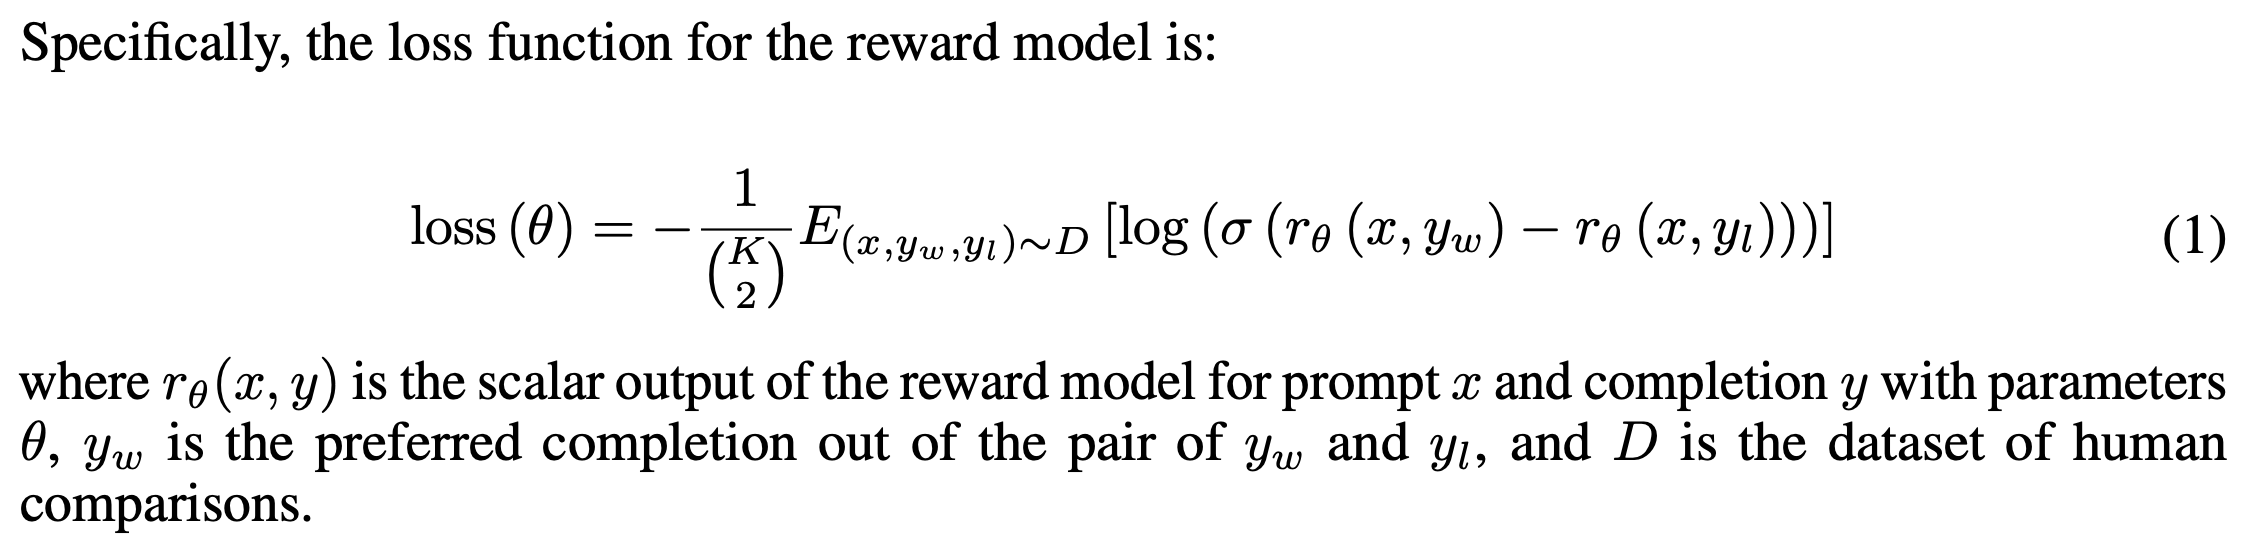

### Model Training

In [ ]:
trainer.train()

print("Saving last checkpoint of the model")
model.save_pretrained(output_name + "_peft_last_checkpoint")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Accuracy
500,0.668900,0.674774,0.653200
1000,0.677300,0.669907,0.661100
1500,0.690800,0.668485,0.662350


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2382: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Saving last checkpoint of the model


### Merging and Uploading to HuggingFace Storage

In [ ]:
model.save_pretrained(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps-lora")
model.push_to_hub(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps-lora", use_temp_dir=False)

In [ ]:
model_rm = model.merge_and_unload()

model_rm.save_pretrained(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps")
model_rm.push_to_hub(f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps", use_temp_dir=False)

In [ ]:
# Load the Lora model
model_rm = AutoModelForSequenceClassification.from_pretrained(
    f"djalexj/bert-base-cased-rm-se-{cfg_reward.train_subset}steps",
    torch_dtype=torch.float16
).to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
input1 = """
[CLS] Question : I just started using timber for logging on android, we are trying to add filenames / class - names to log message.
I was able to add filenames in debug build using debug tree, but I'm not finding a way to add filenames in the release tree.
Is there a possibility to add the filename in the release tree with R8 enabled?
Answer : I got this error by having two different NavControllers in my compose hierarchy as a result of having a composable with a
navController parameter : ` navController : NavController = rememberNavController ( ) `
but not setting it to a common, single root navController. [SEP]
"""

input2 = """
[CLS] Question : I just started using timber for logging on android, we are trying to add filenames / class - names to log message.
I was able to add filenames in debug build using debug tree, but I'm not finding a way to add filenames in the release tree.
Is there a possibility to add the filename in the release tree with R8 enabled?
Answer : I got this because I had set popUpTo my firstFragment and also handled popBackStack onBackPressed. [SEP]
"""

tokens1, tokens2 = (
    tokenizer(input1, truncation=True, return_tensors="pt").to(device),
    tokenizer(input2, truncation=True, return_tensors="pt").to(device),
)

In [ ]:
model_rm.eval()

with torch.no_grad():
    print(f"Input1 Reward estimation: {model_rm(**tokens1)[0].item():.3f}")
    print(f"Input2 Reward estimation: {model_rm(**tokens2)[0].item():.3f}")

Input1 Reward estimation: 0.166
Input2 Reward estimation: 0.106



## RL Fine-Tuning

<div>
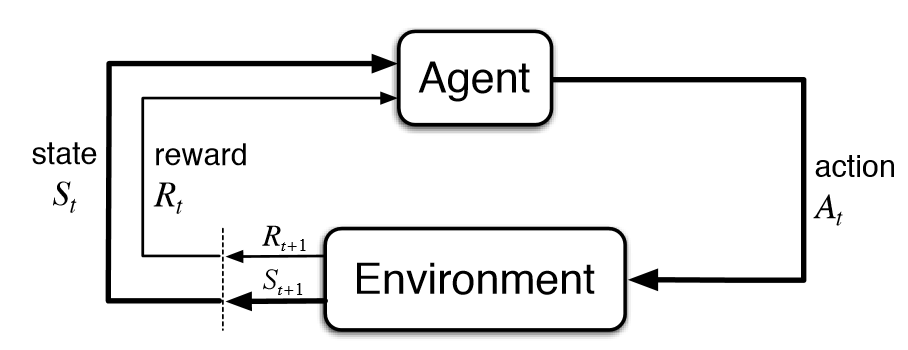
</div>

$R = \sum_{t=0}^T γ^tr_t$ -- Sum of discounted rewards

$V_\pi(s) = \mathbb{E}\big[R | s_0 = s\big] = \mathbb{E} \big[R | s \big]$ -- Value function (expected return starting with state s)

$Q_\pi(s, a) = \mathbb{E}\big[ R | s, a\big]$ -- Action-value function (expected return starting with state s taking action a)

$A_\pi(s, a) = Q_\pi(s, a) - V_\pi(s)$


<div>
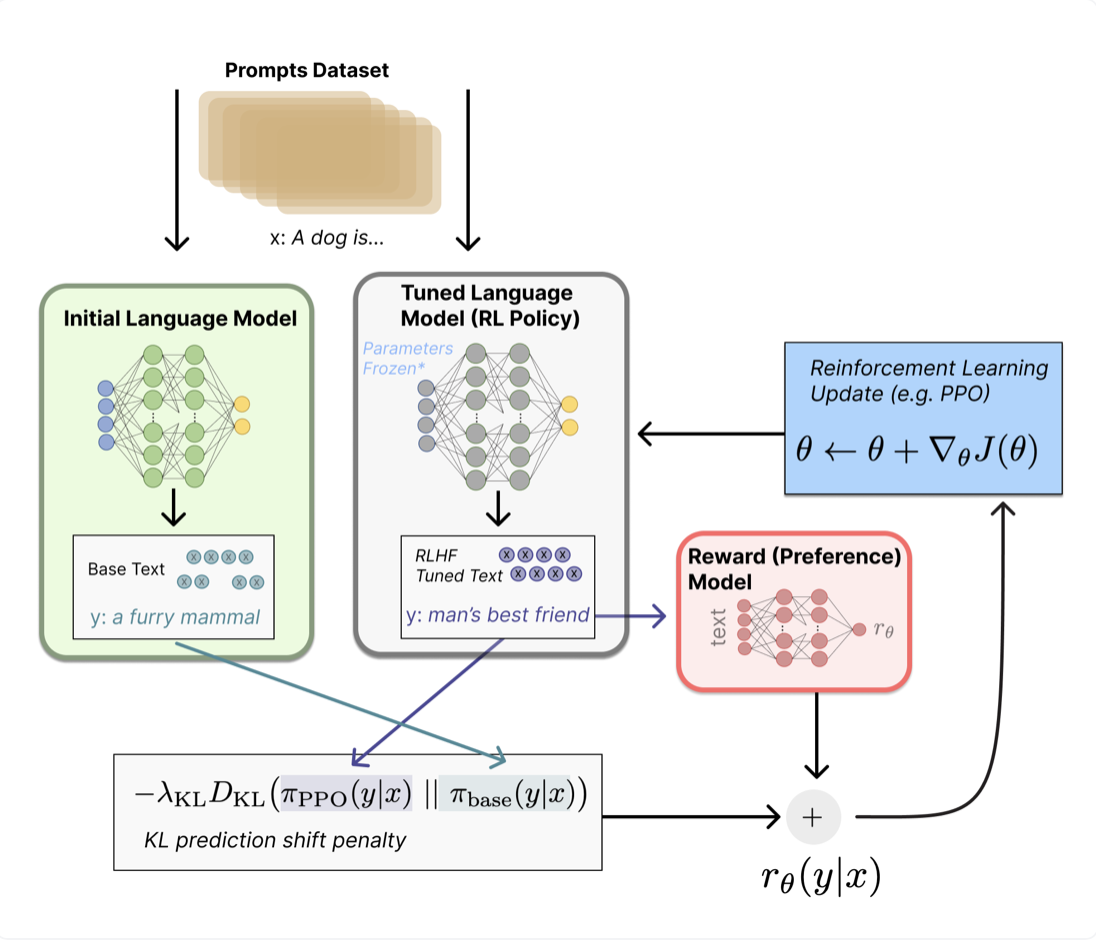
</div>

In [ ]:
from dataclasses import dataclass, field
from typing import Optional

import torch
import addict
from accelerate import Accelerator
from datasets import load_dataset
from peft import PeftModel, LoraConfig, get_peft_model, prepare_model_for_int8_training
from tqdm import tqdm
from transformers import (
    Adafactor,
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    pipeline,
    AutoModelForSequenceClassification
)

from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler

### Config for PPO

In [ ]:
ppo_config = addict.Dict({
    "model_name": "djalexj/gpt-neo-1.3B-sft-se-4000steps",
    "tokenizer_name": "EleutherAI/gpt-neo-1.3B",
    "reward_model_name": "djalexj/bert-base-cased-rm-se-100000steps",
    "reward_tokenizer_name": "bert-base-cased",
    ######
    "learning_rate": 1.4e-5,
    "output_max_length": 128,
    "mini_batch_size": 2,
    "batch_size": 16,
    "ppo_epochs": 3,
    "gradient_accumulation_steps": 4,
    "adafactor": False,
    "early_stopping": True,
    "target_kl": 0.1,
    "reward_baseline": 0.0,
    #######
    "batched_gen": True,
    "save_freq": 50,
    "output_dir": "gpt-neo-1.3B-rlhf-se",
    "seed": 0,
    "log_with": None,

})

In [ ]:
tqdm.pandas()

reward_model_name = ppo_config.reward_model_name
dataset_name = "lvwerra/stack-exchange-paired"

rl_config = PPOConfig(
    model_name=ppo_config.model_name,
    learning_rate=ppo_config.learning_rate,
    log_with=ppo_config.log_with,
    batch_size=ppo_config.batch_size,
    mini_batch_size=ppo_config.mini_batch_size,
    gradient_accumulation_steps=ppo_config.gradient_accumulation_steps,
    optimize_cuda_cache=True,
    early_stopping=ppo_config.early_stopping,
    target_kl=ppo_config.target_kl,
    ppo_epochs=ppo_config.ppo_epochs,
    seed=ppo_config.seed,
)

### Preparing Data

In [ ]:
train_dataset = load_dataset("lvwerra/stack-exchange-paired", data_dir="data/rl", split="train")
train_dataset = train_dataset.select(range(100000))
# We then define the arguments to pass to the sentiment analysis pipeline.
# We set `return_all_scores` to True to get the sentiment score for each token.
sent_kwargs = {"top_k": None, "function_to_apply": "none", "batch_size": 16, "truncation": True}

reward_tokenizer = AutoTokenizer.from_pretrained(ppo_config.reward_tokenizer_name)
tokenizer = AutoTokenizer.from_pretrained(ppo_config.tokenizer_name)
# GPT-2 tokenizer has a pad token, but it is not eos_token by default. We need to set it to eos_token.
# only for this model.
tokenizer.pad_token = tokenizer.eos_token


# Below is an example function to build the dataset. One should customize this function to train the model on
# its own dataset.
def build_dataset(
    tokenizer, dataset_name="lvwerra/stack-exchange-paired", input_min_text_length=2, input_max_text_length=8
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.
    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.
    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """

    ds = load_dataset(dataset_name, data_dir="data/rl", split="train")
    original_columns = ds.column_names
    num_proc = 2

    def preprocess_function(examples):
        new_examples = {
            "query": [],
            "input_ids": [],
        }
        for question in examples["question"]:
            query = "Question: " + question + "\n\nAnswer: "
            tokenized_question = tokenizer(query, truncation=True)
            new_examples["query"].append(query)
            new_examples["input_ids"].append(tokenized_question["input_ids"])

        return new_examples

    ds = train_dataset.map(
        preprocess_function,
        batched=True,
        num_proc=num_proc,
        remove_columns=original_columns,
    )
    ds = ds.filter(lambda x: len(x["input_ids"]) < 512, batched=False)

    ds.set_format(type="torch")
    return ds


# We retrieve the dataloader by calling the `build_dataset` function.
dataset = build_dataset(tokenizer)


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])


# set seed before initializing value head for deterministic eval
set_seed(rl_config.seed)

### LoRA Adapters for RL fine-tune

In [ ]:
# Now let's build the model, the reference model, and the tokenizer.
pretrained_model = AutoModelForCausalLM.from_pretrained(
    rl_config.model_name,
    load_in_8bit=True,
    device_map={"": torch.cuda.current_device()}
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

pretrained_model = prepare_model_for_int8_training(pretrained_model)
pretrained_model.enable_input_require_grads()
pretrained_model = get_peft_model(pretrained_model, lora_config)

pretrained_model.print_trainable_parameters()

# Use trl wrapper for additional ValueHead (critic)
model = AutoModelForCausalLMWithValueHead.from_pretrained(pretrained_model)

optimizer = None
if ppo_config.adafactor:
    optimizer = Adafactor(
        filter(lambda p: p.requires_grad, model.parameters()),
        scale_parameter=False,
        relative_step=False,
        warmup_init=False,
        lr=rl_config.learning_rate,
    )

### Model Training

In [ ]:
# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config=rl_config,
    model=model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [ ]:
# We then build the sentiment analysis pipeline, passing the model name and the
# sentiment analysis pipeline arguments. Let's also make sure to set the device
# to the same device as the PPOTrainer.
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug


reward_model = AutoModelForSequenceClassification.from_pretrained(
    ppo_config.reward_model_name
)

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    device_map={"": torch.cuda.current_device()},
    tokenizer=reward_tokenizer,
)

# We then define the arguments to pass to the `generate` function. These arguments
# are passed to the `generate` function of the PPOTrainer, which is a wrapper around
# the `generate` function of the trained model.
generation_kwargs = {
    # "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": tokenizer.eos_token_id,
}
output_min_length = 32
output_max_length = ppo_config.output_max_length
output_length_sampler = LengthSampler(output_min_length, output_max_length)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


<div>
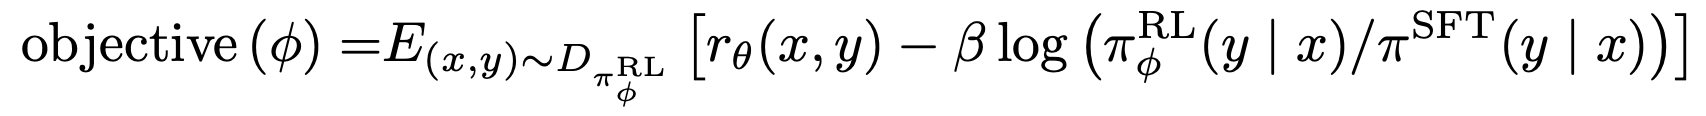
</div>

In [ ]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    question_tensors = batch["input_ids"]

    response_tensors = ppo_trainer.generate(
        question_tensors,
        return_prompt=False,
        length_sampler=output_length_sampler,
        **generation_kwargs,
    )
    batch["response"] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

    # Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[0]["score"] - ppo_config.reward_baseline) for output in pipe_outputs]

    # Run PPO step
    stats = ppo_trainer.step(question_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    if ppo_config.save_freq and epoch and epoch % ppo_config.save_freq == 0:
        ppo_trainer.save_pretrained(ppo_config.output_dir + f"step_{epoch}")

https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py#L537

<div>
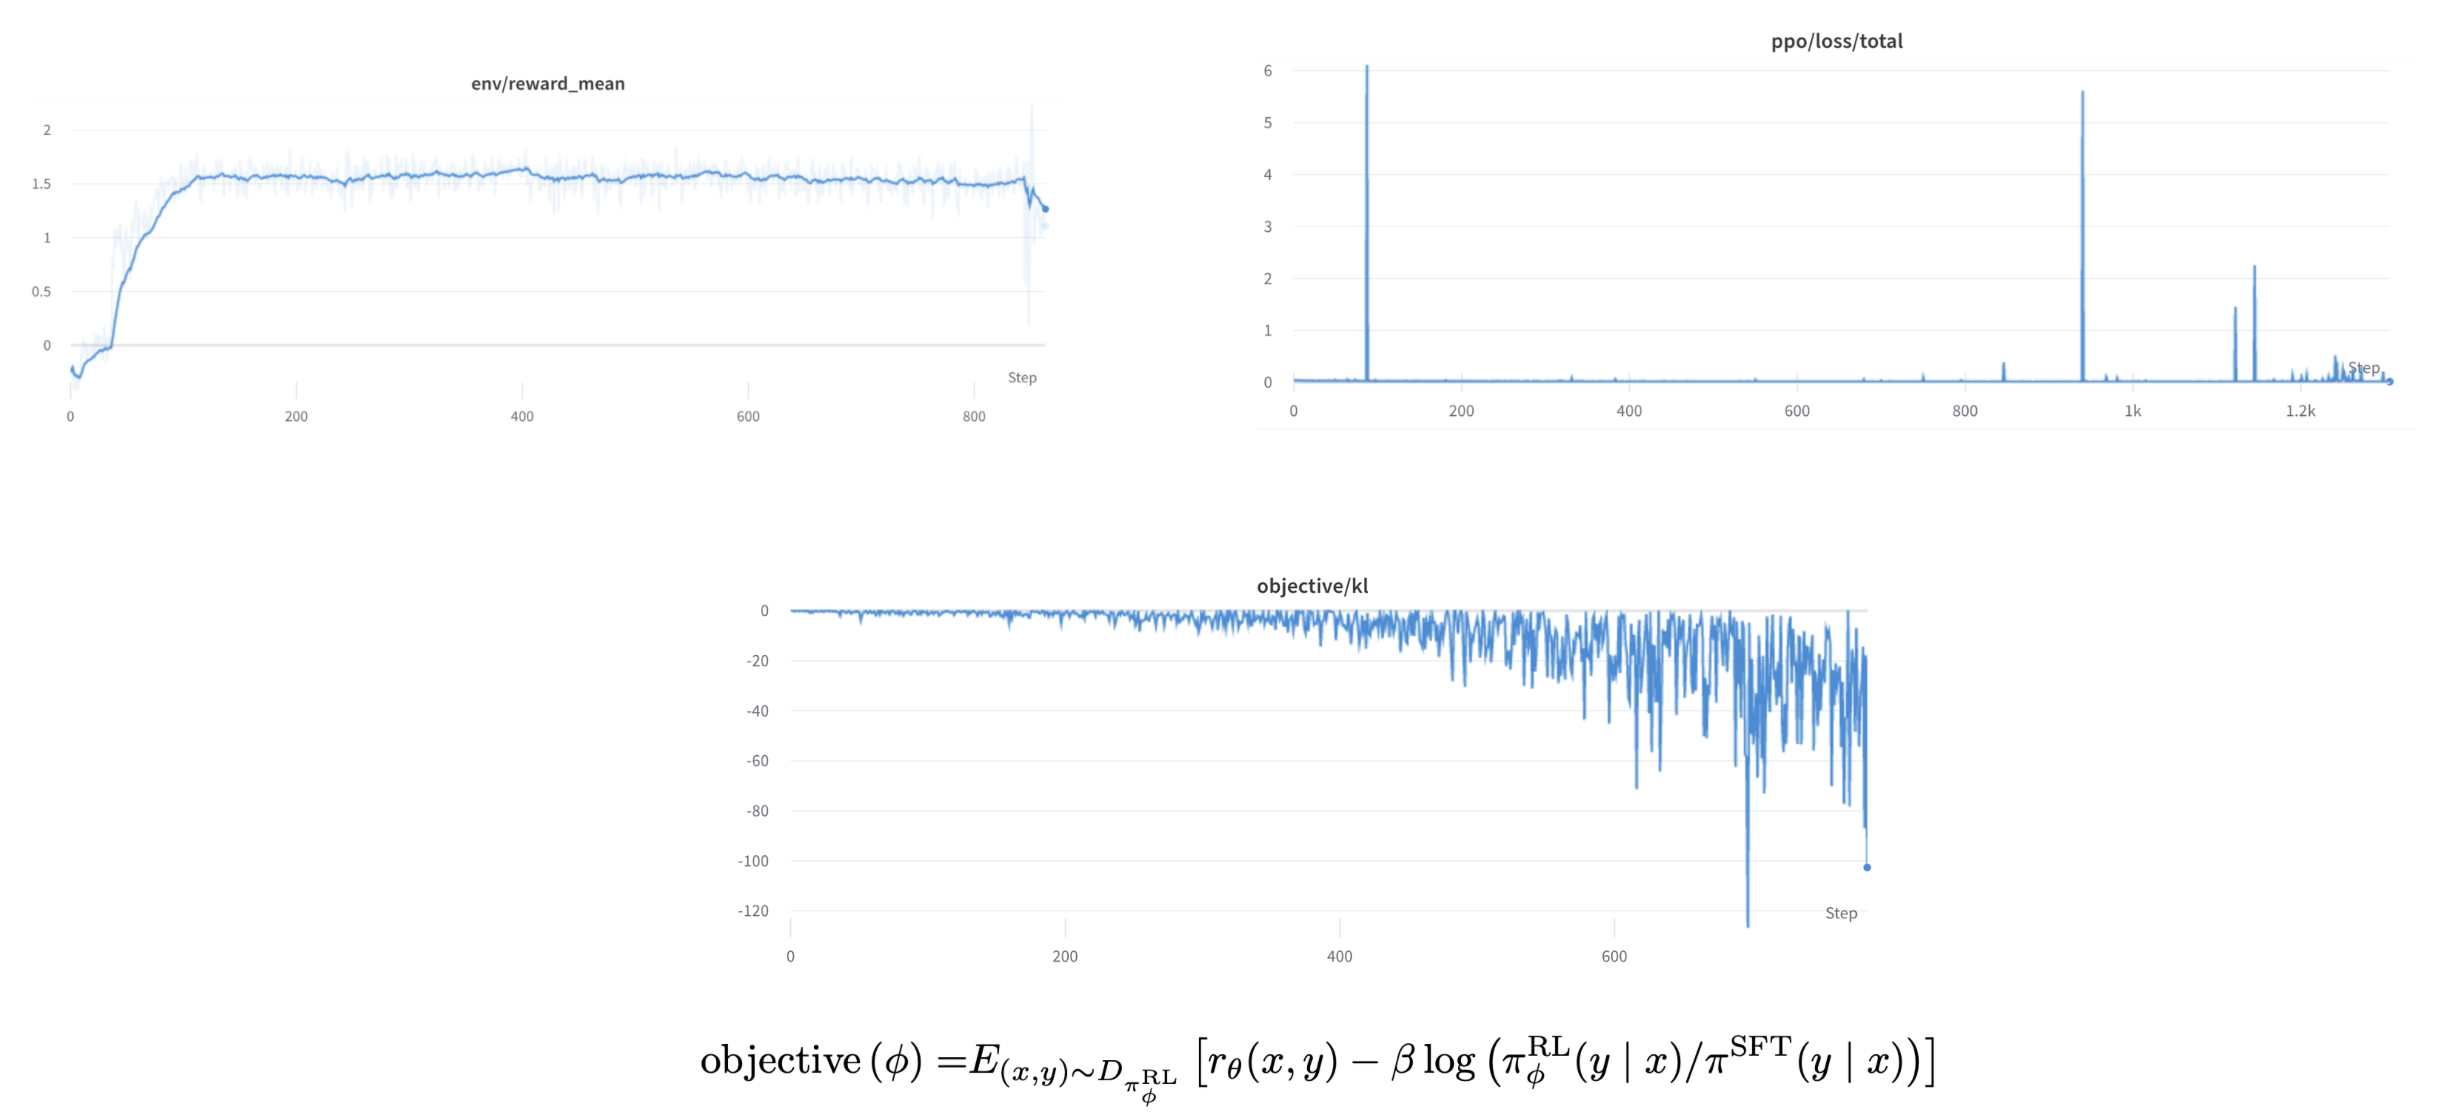
</div>

### Merging and Uploading to HuggingFace Storage

In [ ]:
model_rlhf = AutoModelForCausalLM.from_pretrained(
    "djalexj/gpt-neo-1.3B-sft-se-4000steps",
    torch_dtype=torch.float16,
    device_map={'':torch.cuda.current_device()}
)

model_rlhf = PeftModel.from_pretrained(model_rlhf, "./gpt-neo-1.3B-rlhf-sestep_250")

model_rlhf.save_pretrained(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-lora-latest")
model_rlhf.push_to_hub(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-lora-latest", use_temp_dir=False)

model_rlhf = model_rlhf.merge_and_unload()
model_rlhf.save_pretrained(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest")
model_rlhf.push_to_hub(f"djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest", use_temp_dir=False)

In [ ]:
model = AutoModelForCausalLM.from_pretrained("djalexj/gpt-neo-1.3B-rlhf-se-250steps-latest")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

generate_eval(model, tokenizer)

Starting Evaluation...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: How to create an attention layer in pytorch?    Answer:
``` import torch import torch.nn as nn import torch.nn.functional as F
class Attention(nn.Module):     def __init__(self, input_dim,
output_dim, attention_dim):         super(Attention, self).__init__()
self.input_dim = input_dim         self.output_dim = output_dim
self.attention_dim = attention_dim
****************************************************************************************************


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




 Question: I recieve TypeError with a following code: ```a=[1, 2, 3]
a.extend(4)```. How can I fix it?     Answer:   ``` a = [1, 2, 3]
a.extend(4)  ```  This is because you are trying to extend an empty
list.  You can use the `extend` method to extend a list with another
list.  ``` a = [1, 2, 3] a.extend([4])  ```  This will give you a list
with 4 elements.  ``` a = [1, 2, 3] a.extend([4])  ```  This will give
****************************************************************************************************


 Question: What library would you recommend for visualizing 3D points
in python?    Answer:   I would recommend the
[`pyOpenGL`](http://pyopengl.sourceforge.net/) library. It is a very
powerful library that can be used to create 3D graphics. It is very
easy to use and has a very good documentation.  I have used it to
create a 3D model of a car. It is very easy to use and has a very good
documentation.  I have also used it to create a 3D model of a house.
It is very easy to use

All models are available in https://huggingface.co/djalexj

If have any questions, DM me in Singularis (@alex_golubev) or LinkedIn (https://www.linkedin.com/in/alexander-golubev-79064117b/)



---



## References:
### Papers:
Instruct GPT - https://arxiv.org/abs/2203.02155

LLM.int8() quantization - https://arxiv.org/abs/2208.07339

LoRA adapters - https://arxiv.org/abs/2106.09685

PPO algorithm - https://arxiv.org/abs/1707.06347

### Sources:
TRL ppo implementation - https://github.com/lvwerra/trl/blob/main/trl/trainer/ppo_trainer.py

Efficient single-GPU training - https://huggingface.co/docs/transformers/perf_train_gpu_one

HuggingFace StackExchange Dataset - https://huggingface.co/datasets/HuggingFaceH4/stack-exchange-preferences (https://huggingface.co/datasets/lvwerra/stack-exchange-paired)

HuggingFace posts on fine-tuning LLMs:


1.   Fine-tuning 20B LLMs with RLHF on a 24GB consumer GPU - https://huggingface.co/blog/trl-peft
2.   StackLLaMA: A hands-on guide to train LLaMA with RLHF - https://huggingface.co/blog/stackllama


